In [1]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')
import time

from matplotlib import pyplot as plt

%matplotlib inline

Firstly, we will download the CIFAR-10 dataset into the terminal.

In [2]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -vxf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2022-05-05 23:50:56--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  17.0MB/s    in 11s     

2022-05-05 23:51:07 (15.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Then, we define the path of the folder in which the dataset is present and unpickle the files to load the dataset.

In [3]:
# Loading the dataset
ROOT_PATH='./'

In [4]:
# Function to read the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# Reading the dataset
batch1 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_1")
batch2 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_2")
batch3 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_3")
batch4 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_4")
batch5 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_5")
test_batch = unpickle(ROOT_PATH+"cifar-10-batches-py/test_batch")

Here, we define functions to load the dataset into x_train, y_train, x_test and y_test variables.

In [6]:
# Function to load the data
def load_data0(btch):
    labels = btch[b'labels']
    imgs = btch[b'data'].reshape((-1, 32, 32, 3))
    
    res = []
    for ii in range(imgs.shape[0]):
        img = imgs[ii].copy()
        img = np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1))
        res.append(img)
    imgs = np.stack(res)
    return labels, imgs

In [7]:
# Function to load the data
def load_data():
    x_train_l = []
    y_train_l = []
    for ibatch in [batch1, batch2, batch3, batch4, batch5]:
        labels, imgs = load_data0(ibatch)
        x_train_l.append(imgs)
        y_train_l.extend(labels)
    x_train = np.vstack(x_train_l)
    y_train = np.vstack(y_train_l)
    
    x_test_l = []
    y_test_l = []
    labels, imgs = load_data0(test_batch)
    x_test_l.append(imgs)
    y_test_l.extend(labels)
    x_test = np.vstack(x_test_l)
    y_test = np.vstack(y_test_l)
    return (x_train, y_train), (x_test, y_test)

In [8]:
# Loading the data into train and test variables
(x_train, y_train), (x_test, y_test) = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
del batch1, batch2, batch3, batch4, batch5, test_batch

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Then, we reshape the data to use it for further processing.

In [9]:
# Reshaping the data
x_train = x_train.reshape(50000, 3*32*32)
x_test = x_test.reshape(10000, 3*32*32)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [10]:
# Defining the classes for the images
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Firstly, we normalize the x_train and x_test data using Normalizer() from Scikit Learn so that we can get the data in unit norm.

In [11]:
# Normalizing the train and test data
norm = Normalizer()
x_train_norm = norm.fit_transform(x_train)
x_test_norm = norm.transform(x_test)
print(x_train_norm[0])

[0.0091949  0.00966243 0.00981828 ... 0.01916902 0.0143378  0.01122089]


Then, Logistic Regression model with 4-fold CV and l2 penalty is built using LogisticRegression() from Scikit Learn. The 'saga' solver has been used as it works best on large dataset with scaled or normalized data.

In [12]:
# Logistic Regression Variation 3: 'saga' solver, 4-fold cross validation with 
# l2 penalty
def lr_l2():
  print(f'Logistic Regression with \'saga\' solver, 4-fold cross validation with '
  'l2 penalty')
  # Fitting the normalized data
  lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga')
  lr_l2.fit(x_train_norm, y_train)

  # Predicting the labels for the train data and calculating the accuracy
  predicted_labels = lr_l2.predict(x_train_norm[:15000])
  np.unique((y_train==0).astype(np.int8))
  train_accuracy = accuracy_score(y_train[:15000], predicted_labels)
  print(f'Train accuracy: {train_accuracy}')

  # Predicting the labels for the test data and calculating the accuracy
  test_predicted = lr_l2.predict(x_test_norm)
  test_accuracy = accuracy_score(y_test, test_predicted)
  print(f'Test accuracy: {test_accuracy}')
  return lr_l2

Here, we train the different models on the train data and then get predict the labels for the test data. Following are the accuracies for the different models.

In [13]:
start = time.time()
model = lr_l2()
print(f'Time taken to train the model: {time.time()}')
end = time.time()

Logistic Regression with 'saga' solver, 4-fold cross validation with l2 penalty
Train accuracy: 0.43633333333333335
Test accuracy: 0.4148
Time taken to train the model: 1651808497.9384294


In [14]:
print(f'Time taken for training: {(end - start):.2f}s')

Time taken for training: 13816.66s


In [15]:
# Defining lists to store model labels and test accuracies
train_acc = [43.63, 47.71, 90.48]
test_acc = [41.48, 45.94, 89.25]
model_labels = ['Logistic Regression', 'SVM', 'CNN']

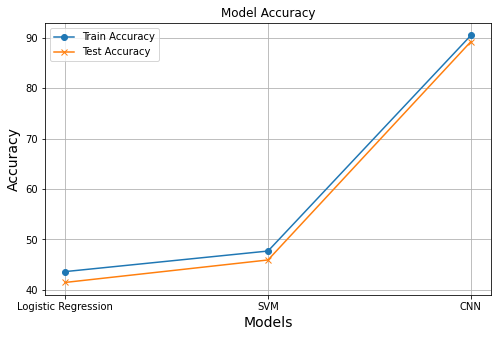

In [23]:
plt.figure(figsize=(8,5))
plt.plot(model_labels, train_acc, label='Train Accuracy', marker='o')
plt.plot(model_labels, test_acc, label='Test Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid()
plt.legend()